### Multivariate Time Series Forecasting with LSTM


* 이전 24시간 동안의 기상상태와 오염도를 정보로 하여 그 다음 step의 오염도를 예측하는 문제

In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Data Load

In [3]:
def parse(x):
  return datetime.strptime(x, '%Y %m %d %H')

In [4]:
dataset = read_csv('/content/drive/MyDrive/CDS2(2022-2)/SigDataset/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']],
                 index_col=0, date_parser=parse)

In [5]:
dataset

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


No: row number<br>
year: year of data in this row<br>
month: month of data in this row<br>
day: day of data in this row<br>
hour: hour of data in this row<br>
pm2.5: PM2.5 concentration<br>
DEWP: Dew Point<br>
TEMP: Temperature<br>
PRES: Pressure<br>
cbwd: Combined wind direction<br>
Iws: Cumulated wind speed<br>
Is: Cumulated hours of snow<br>
Ir: Cumulated hours of rain<br>

* Data Preprocessing

In [6]:
dataset.drop('No', axis=1, inplace=True)
# row number

In [7]:
dataset.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [8]:
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# 이름을 이해하기 편하게 다시 변경
dataset.index.name = 'date'
# index 이름도 date로 변경

In [9]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [10]:
dataset['pollution'].fillna(0, inplace=True)
# 오염 정도가 비어있는 값은 0으로 채운다.

In [11]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [12]:
dataset = dataset[24:]
# 24시간 동안의 기상상태와 오염도를 정보로 하여 그 다음 시점의 오염도를 예측하기에, 첫 24시간 정보 삭제

* 데이터 저장 및 Load

In [13]:
dataset.to_csv('/content/drive/MyDrive/CDS2(2022-2)/SigDataset/pollution.csv')
# 처리가 완료된 데이터를 다시 저장해둠.

In [14]:
dataset = read_csv('/content/drive/MyDrive/CDS2(2022-2)/SigDataset/pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [15]:
values = dataset.values
# 값만 따로 할당
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

* 각 변수의 추이 시각화

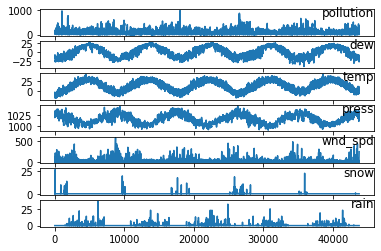

In [16]:
groups = [0, 1, 2, 3, 5, 6, 7]
# 범주형 변수 제외
i = 1

plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1

* 범주형 변수 인코딩

In [17]:
values[:,4]

array(['SE', 'SE', 'SE', ..., 'NW', 'NW', 'NW'], dtype=object)

In [18]:
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 범주형 변수를 label로 인코딩한다.
values = values.astype('float32')

In [20]:
values[:,4]

array([2., 2., 2., ..., 1., 1., 1.], dtype=float32)

In [21]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# minmax scaling

* t-1시점, t시점 데이터를 한 행으로 만드는 함수

In [22]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  
  n_vars = data.shape[1]
  # data shape의 두번째 value 즉 feature 갯수
  
  df = DataFrame(data)
  # dataframe으로 만들기
  
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)

  for i in range(n_in, 0, -1):
    # n_in부터 0까지 -1씩 줄어들면서 반복
      cols.append(df.shift(i))
      # df를 i칸 내린 다음 cols에 더하기
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
      # var1, var2 .... 

  for i in range(0, n_out):
    # 0에서 n_out까지 반복
      cols.append(df.shift(-i))
      # df를 i칸 올린 다음 cols에 더하기
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
      # var name

  agg = pd.concat(cols, axis=1)
  agg.columns = names

  if dropnan:
      agg.dropna(inplace=True)
      # 비어있는 값이 있다면 drop
  return agg

In [23]:
reframed = series_to_supervised(scaled, 1, 1)
# t-1, t 시점 데이터를 한행으로 하도록 구성

* var(t-1)은 var(t)보다 1-step 이전이다. t-1의 feature로 t를 예측

In [24]:
scaled

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

→ 오염정도, feature1, feature2, ... feature7 이렇게 구성되어있다. 그런데 우리는 t-1 step의 오염정도, feature1, feature2... feature7을 학습해서 t step에서의 오염정도를 예측하고 싶다.

In [25]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


→ 우리가 원하는데로 되어있다. 첫번째 행을 보면 var(t-1)에서 var8(t-1)까지는 이전 step 정보 var1(t)는 현재 step, 즉 예측해야하는 값이 되었다.

In [26]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)',
       'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)'],
      dtype='object')

* 사용하지 않는 변수 제거

In [27]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [28]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


* Train/Test split

In [29]:
values = reframed.values
# 데이터 값만 다시 할당
n_train_hours = 365 * 24 
#1년치 데이터만 가져온다
train = values[:n_train_hours, :]
# 1년치 데이터 train
test = values[n_train_hours:, :]
# 나머지 데이터 test

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# X, y분할

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# reshape input to be 3D [samples, timesteps, features]

In [30]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [31]:
train_X[0]

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ]], dtype=float32)

In [32]:
train_y[0]

0.14889336

In [33]:
train_X[1]

array([[0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ]], dtype=float32)

In [34]:
train_y[1]

0.15995975

→ 8개의 변수의 값들이 순차적으로 입력값이 되어 시간적인 정보를 학습할 수 있게 input 구성(이전의 오염정보를 포함한 정보) <br>
그 다음 시점의 오염도를 y_label로 구성

* Model 

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(20, return_sequences = False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

* train

In [36]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
        validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 8s - loss: 0.0664 - val_loss: 0.0606 - 8s/epoch - 69ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0526 - val_loss: 0.0638 - 1s/epoch - 12ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0271 - val_loss: 0.0482 - 1s/epoch - 12ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0197 - val_loss: 0.0452 - 2s/epoch - 15ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0183 - val_loss: 0.0389 - 2s/epoch - 15ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0172 - val_loss: 0.0324 - 1s/epoch - 12ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0166 - val_loss: 0.0266 - 1s/epoch - 12ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0159 - val_loss: 0.0212 - 2s/epoch - 15ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0156 - val_loss: 0.0179 - 1s/epoch - 11ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0151 - val_loss: 0.0178 - 1s/epoch - 12ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0169 - 1s/epoch - 12ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0156 - 1s/epoch - 12ms/step
Epoch 13/50
122/122 - 1s 

* Result

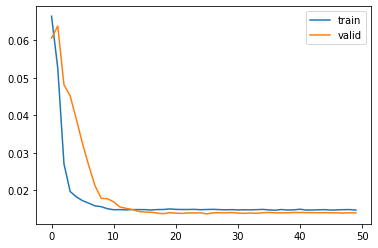

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

* Test

In [38]:
yhat = model.predict(test_X)
# 학습한 모델에 test_X를 입력하여 y값을 예측

In [39]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 예측 데이터를 전처리 하기 전 단계로 데이터 변환 → 원래의 값과 명확한 비교를 위해

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 실제 데이터를 전처리 하기 전 단계로 데이터 변환 → 원래의 값과 명확한 비교를 위해

In [40]:
inv_y[:10]

array([31., 20., 19., 18., 17., 14., 14., 22., 22., 25.], dtype=float32)

In [41]:
inv_yhat[:10]

array([33.362843, 29.28468 , 19.30427 , 18.26503 , 17.860302, 16.633888,
       13.775243, 14.274771, 21.126028, 20.800179], dtype=float32)

In [42]:
inv_y[-10:]

array([ 9., 11.,  8.,  9., 10.,  8., 10., 10.,  8., 12.], dtype=float32)

In [43]:
inv_yhat[-10:]

array([8.896271 , 6.8222165, 8.5429125, 6.1233625, 7.070334 , 8.178159 ,
       6.1910477, 8.193564 , 8.163254 , 6.6048503], dtype=float32)

In [44]:
min(inv_y), max(inv_y), min(inv_yhat), max(inv_yhat)

(0.0, 994.0, -14.671905, 786.44604)

* rmse

In [45]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

In [47]:
rmse

27.177906

* 시각화

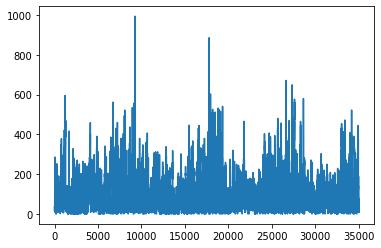

In [48]:
plt.plot(inv_y)
plt.show()

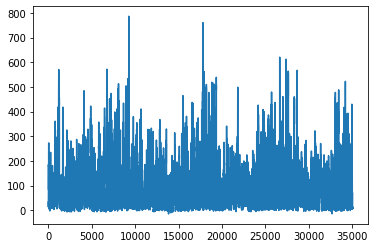

In [49]:
plt.plot(inv_yhat)
plt.show()

* 일부 시각화

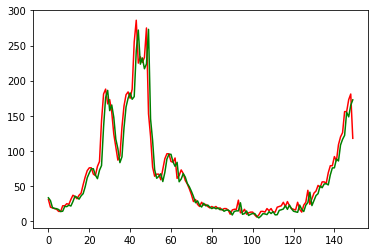

In [50]:
plt.plot(inv_y[:150], color='r')
plt.plot(inv_yhat[:150], color='g')
plt.show()

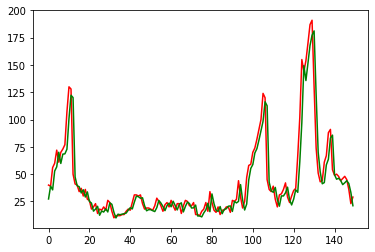

In [51]:
plt.plot(inv_y[350:500], color='r')
plt.plot(inv_yhat[350:500], color='g')
plt.show()